<a href="https://colab.research.google.com/github/khashayar-bo/CellParameter-Estimation/blob/main/ParameterEstimation_NLME_NTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports, Confiugrations and Functions

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
from scipy.optimize import minimize

## This Class stores the data of the cells

In [ ]:
class CellData:
  """
  This class stores the observed data from a cell
  """

  # This is the constructor for this class
  def __init__(self, cellDataframe, cellNum):
    self.mRNAData = cellDataframe.iloc[0:22,cellNum ].to_numpy()
    self.darkData = cellDataframe.iloc[22:44,cellNum].to_numpy()
    self.fluoresentData = cellDataframe.iloc[44:66,cellNum].to_numpy()

  # This function returns the mRNA data
  def getmRNAData(self):
    return self.mRNAData.reshape(22, 1)

  # This function returns the dark protein data
  def getDarkProteinData(self):
    return self.darkData.reshape(22, 1)

  # This function returns the fluorescent data
  def getFluorescentData(self):
    return self.fluoresentData.reshape(22, 1)

  # This function returns all of the data together with a matrix
  def getCellData(self):
    mRNA = self.mRNAData.reshape(self.mRNAData.shape[0], 1)
    dark = self.darkData.reshape(self.darkData.shape[0], 1)
    fluorescent = self.fluoresentData.reshape(self.fluoresentData.shape[0], 1)
    finalData = np.append(mRNA, dark, axis=1)
    finalData = np.append(finalData, fluorescent, axis=1)

    return finalData

## This class contains the optimizer functions

In [ ]:
class Optimizer:
  """
  This class serves as the optimizer. It has some functions that upon calling 
  can further make progress in the optimizations
  """

  def __init__(self, t, boundarykrkp, boundarykdr, boundarykdp, boundarykm, cellData):
    self.t = t
    self.initializeBoundaries(boundarykrkp, boundarykdr, boundarykdp, boundarykm)
    self.currentResult = np.array([0.3, 0.04, 0.3, 0.007, 0.025])
    self.currentResult = np.append(self.currentResult, np.array([2,2,2,2,2,2,2,2,2]))
    self.previousResult = self.currentResult
    self.cellData = cellData
  

  # This function contains the ODEs of the defined model
  def ODEs(self, x, t, kr, kdr, kp, kdp, km):
    # Assigning Values
    m = x[0]
    Pd = x[1]
    Pf = x[2]
  
    # Definig the ODEs
    dmdt = kr - kdr * m
    dPddt = kp * m - kdp * Pd - km * Pd
    dPfdt = km * Pd - kdp * Pf

    return [dmdt, dPddt, dPfdt]


  # The log likelihood function that should be minimized
  def logLikelihood(self, currentStatus):

    # Initialzing the sigma vectors
    sigma1 = np.ones((22, 1)) * currentStatus[5]
    sigma2 = np.ones((22, 1)) * currentStatus[6]
    sigma3 = np.ones((22, 1)) * currentStatus[7]
    sigma = np.concatenate((sigma1, sigma2, sigma3), axis=1)

    # Initializing the theta0 vector
    theta01 = np.ones((22, 1)) * currentStatus[8]
    theta02 = np.ones((22, 1)) * currentStatus[9]
    theta03 = np.ones((22, 1)) * currentStatus[10]
    theta0 = np.concatenate((theta01, theta02, theta03), axis=1)
    
    # Initializing theta1 vector
    theta11 = np.ones((22, 1)) * currentStatus[11]
    theta12 = np.ones((22, 1)) * currentStatus[12]
    theta13 = np.ones((22, 1)) * currentStatus[13]
    theta1 = np.concatenate((theta11, theta12, theta13), axis=1)


    predictedValues = odeint(self.ODEs, [0, 0, 0], t, args=(currentStatus[0], currentStatus[1], currentStatus[2], currentStatus[3], currentStatus[4],))
    logLikelihoodValue = self.cellData.getCellData() - predictedValues
    logLikelihoodValue = np.divide(logLikelihoodValue, sigma)
    
    gVector = self.g(theta0, theta1, self.cellData.getCellData())
    logLikelihoodValue = np.divide(logLikelihoodValue, gVector)
    logLikelihoodValue = logLikelihoodValue ** 2
    logLikelihoodValue *= -0.5
    
    logLikelihoodValue -= np.log(np.multiply(sigma, gVector))
    
    return -1 * np.sum(logLikelihoodValue)

  # The g function which would model the noise
  def g(self, theta0, theta1, observedData):
    return theta0 + theta1 * observedData

  
  # This function optimizes the log-likelihood function with both parameters
  def optimizeLogLikelihood(self):
    self.previousResult = self.currentResult
    currentState = self.currentResult
    solution = minimize(self.logLikelihood, currentState, method='L-BFGS-B', bounds=self.bound, options={"maxiter":10000, "maxfun":10000})
    
    if solution['success'] == True:
      print("Optimization Successful")
      result = solution['x']

      self.currentResult = result

    else:
      print("Optimization Failed")

  def optimizeCellParameters(self):
    # Lambda fucntion that only considers the cell parameters
    
    self.previousResult = self.currentResult
    loglikCellParameters = lambda x: self.logLikelihood(np.concatenate((x, np.array([1, 1, 1, 1, 1, 1, 0, 0, 0]))))
    input = self.currentResult[0:5]
    solution = minimize(loglikCellParameters, input, method='L-BFGS-B', bounds=self.bound, options={"maxiter":100000, "maxfun":100000})

    if solution['success'] == True:
      print("Optimization Successful")
      result = solution['x']

      self.currentResult[0:5] = result

    else:
      print("Optimization Failed")

  def optimizeScaleParameters(self):
    self.previousResult = self.currentResult
    

    # Lambda fucntion that only considers the scale parameters
    loglikScaleParameters = lambda x: self.logLikelihood(np.concatenate((x, np.array([1, 1, 1, 1, 1, 1, 0, 0, 0]))))
    solution = minimize(loglikCellParametersOnly, initialVector, method='L-BFGS-B', bounds=self.bound, options={"maxiter":100000, "maxfun":100000})
    print(solution)

    if solution['success'] == True:
      print("Optimization Successful")
      result = solution['x']
      
      self.currentResult = result

    else:
      print("Optimization Failed")

  # This function initilaizes the boundaries
  def initializeBoundaries(self, boundarykrkp, boundarykdr, boundarykdp, boundarykm):
    otherboundaries = (0.0001, 100000)
    bound = [boundarykrkp, boundarykdr, boundarykrkp, boundarykdp, boundarykm]
    for i in range(9):
      bound.append(otherboundaries)

    bound = tuple(bound)
    self.bound = bound

In [ ]:
# Loading cell1 Data as a sample
cell1Data = CellData(pd.read_csv("data.csv"), 1)

# Initializing Time
t = np.array([0, 5])
t = np.append(t, np.arange(10, 201, 10))

# First the boundaries and the constraints are set
boundarykrkp = (0.001, 1)
boundarykdr = (0.035, 0.07)
boundarykdp = (0.005, 0.008)
boundarykm = (0.02, 0.03)

#Initializing the optimizer
optimizer = Optimizer(t, boundarykrkp, boundarykdr, boundarykdp, boundarykm, cell1Data)

optimizer.optimizeCellParameters()

ValueError: ignored

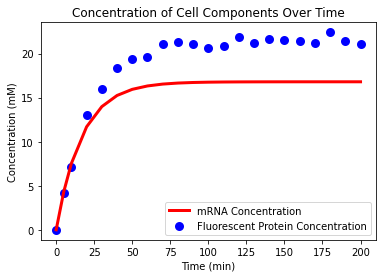

In [ ]:
import matplotlib.pyplot as plt
t = np.array([0, 5])
t = np.append(t, np.arange(10, 201, 10))
plt.plot(t, predictedValues[:,0], linewidth=3, color='red', label="mRNA Concentration")
plt.scatter(t, cell1Data[:t.shape[0]], linewidth=3, color='blue', label="Fluorescent Protein Concentration")


plt.title("Concentration of Cell Components Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mM)")
plt.legend()
plt.show()

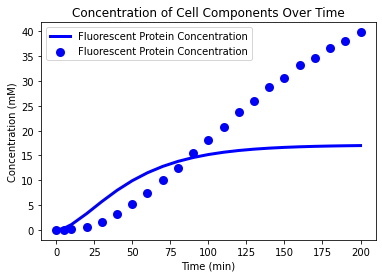

In [ ]:
import matplotlib.pyplot as plt
t = np.array([0, 5])
t = np.append(t, np.arange(10, 201, 10))

plt.plot(t, predictedValues[:,1], linewidth=3, color='blue', label="Fluorescent Protein Concentration")
plt.scatter(t, cell1Data[t.shape[0] * 2:66], linewidth=3, color='blue', label="Fluorescent Protein Concentration")

plt.title("Concentration of Cell Components Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mM)")
plt.legend()
plt.show()

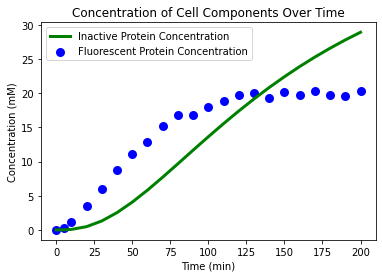

In [ ]:
import matplotlib.pyplot as plt
t = np.array([0, 5])
t = np.append(t, np.arange(10, 201, 10))

plt.plot(t, predictedValues[:,2], linewidth=3, color='green', label="Inactive Protein Concentration")
plt.scatter(t, cell1Data[t.shape[0]:t.shape[0] * 2], linewidth=3, color='blue', label="Fluorescent Protein Concentration")

plt.title("Concentration of Cell Components Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mM)")
plt.legend()
plt.show()